In [337]:
using Plots, Statistics
using Lux, DiffEqFlux, StochasticDiffEq, DiffEqBase.EnsembleAnalysis
using NNlib, Optimisers, Random, Statistics, Zygote
using RecursiveArrayTools
using ComponentArrays
using BenchmarkTools
using SciMLSensitivity

In [349]:
u0 = Float64[50.; 0.;0]
datasize = 30
tspan = (0.0f0, 10.0f0)
tsteps = range(tspan[1], tspan[2], length = datasize)

0.0f0:0.3448276f0:10.0f0

In [350]:
function trueSDEfunc(du, u, p, t)
    R1 = 0.2*u[1]
    R2 = 0.1*u[1]
    du[1] = R1-R2
    du[2] = R1
    du[3] = R2
end

function true_noise_func(du, u, p, t)
    R1 = 0.2*u[1]
    R2 = 0.1*u[1]
    du[1, 1] = sqrt.(R1)[1]
    du[1, 2] = -sqrt.(R2)[1]
    du[2, 1] = sqrt.(R1)[1]
    du[3, 2] = 0
    du[3, 1] = 0
    du[3, 2] = sqrt.(R2)[1]
end
prob_truesde = SDEProblem(trueSDEfunc, true_noise_func, [50,0,0], tspan, noise_rate_prototype = zeros(3, 2))
nothing

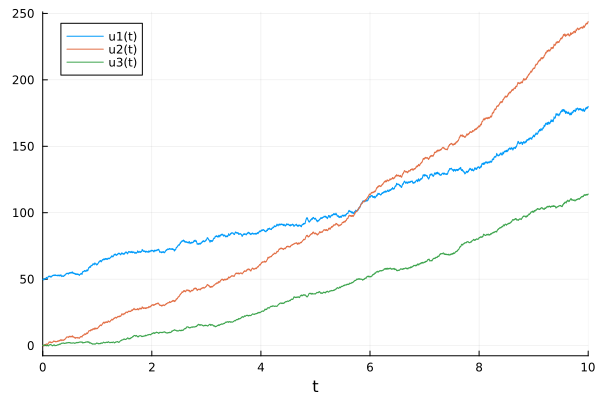

In [351]:
sol = solve(prob_truesde, EM(), dt=0.001)
plot(sol)

In [5]:
ensembleprob = EnsembleProblem(prob_truesde)
@time sol = solve(ensembleprob, EM(), dt=0.05, saveat = 0.05, trajectories = 1000)
truemean = mean(sol, dims = 3)[:, :]
truevar = var(sol, dims = 3)[:, :]

  1.734899 seconds (3.68 M allocations: 194.769 MiB, 3.12% gc time, 96.84% compilation time)


3×201 Matrix{Float64}:
 0.0  0.684186  1.46952   2.31131  3.03603  …   681.94    692.125   701.855
 0.0  0.452106  0.910325  1.42857  1.91245     1079.86   1100.46   1119.63
 0.0  0.247224  0.532332  0.79066  1.02605      115.605   118.229   119.448

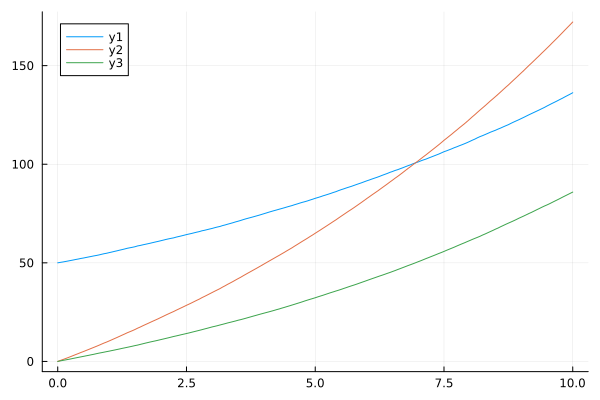

In [6]:
plot(LinRange(0,10,201),truemean')

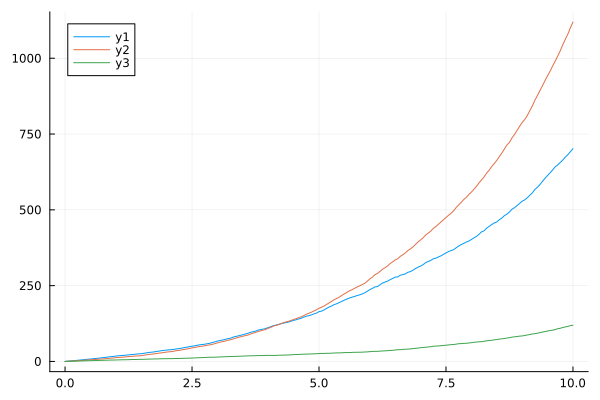

In [7]:
plot(LinRange(0,10,201),truemean')

In [249]:
rng = Random.default_rng()

TaskLocalRNG()

In [292]:
function ratestodrift(R)
    R1,R2 = (abs(R0) for R0 in R)
    return [R1-R2,R1,R2]
end

function ratestodiff(R)
    R1,R2 = (abs(R0) for R0 in R)
    return [[sqrt.(R1),sqrt.(R1),0] [-sqrt.(R2),0,sqrt.(R2)]]
end

ratestodiff (generic function with 1 method)

In [340]:
ratesmodel = Lux.Chain((x -> [x[1]]),Lux.Dense(1 => 16, relu), Lux.Dense(16 => 2))
p1, st1 = Lux.setup(rng, ratesmodel)
cp1 = ComponentArray(p1)
#neuralsde = NeuralDSDE(drift_dudt, diffusion_dudt, tspan, SOSRI(),saveat = tsteps, reltol = 1e-1, abstol = 1e-1)
#nothing

ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (weight = Float32[0.5472017; 0.2987303; … ; 0.3791122; -0.4024242;;], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.34229818 0.08720083 … 0.03644359 -0.20620234; 0.47853842 0.23466878 … -0.09873956 0.2593574], bias = Float32[0.0; 0.0;;]))

In [341]:
ratesmodel

Chain(
    layer_1 = WrappedFunction(#153),
    layer_2 = Dense(1 => 16, relu),     # 32 parameters
    layer_3 = Dense(16 => 2),           # 34 parameters
)         # Total: 66 parameters,
          #        plus 0 states, summarysize 32 bytes.

In [352]:
driftmodel = Lux.Chain(ratesmodel,(x -> ratestodrift(x)))
p2, st2 = Lux.setup(rng, driftmodel)
cp2 = ComponentArray(p2)

diffmodel = Lux.Chain(ratesmodel,(x -> ratestodiff(x)))
p3, st3 = Lux.setup(rng, driftmodel)
cp3 = ComponentArray(p3)

neuralsde = NeuralSDE(driftmodel,diffmodel,tspan,2,alg=EM(),dt = 0.05,sensealg=BacksolveAdjoint())

p4, st4 = Lux.setup(rng, neuralsde)
cp4 = ComponentArray(p4)
cp4alt = ComponentArray(drift = cp2, diffusion = cp2)

ComponentVector{Float32}(drift = (layer_1 = Float32[], layer_2 = (weight = Float32[-0.47875115; 0.3970557; … ; -0.38308653; 0.039585184;;], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.0982551 0.24809657 … 0.04732931 0.038123485; 0.093182385 0.2438022 … 0.088734604 0.059701316], bias = Float32[0.0; 0.0;;]), layer_4 = Float32[]), diffusion = (layer_1 = Float32[], layer_2 = (weight = Float32[-0.47875115; 0.3970557; … ; -0.38308653; 0.039585184;;], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.0982551 0.24809657 … 0.04732931 0.038123485; 0.093182385 0.2438022 … 0.088734604 0.059701316], bias = Float32[0.0; 0.0;;]), layer_4 = Float32[]))

In [353]:
typeof(cp4.drift)

ComponentVector{Float32, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{Axis{(layer_1 = 1:0, layer_2 = ViewAxis(1:32, Axis(weight = ViewAxis(1:16, ShapedAxis((16, 1), NamedTuple())), bias = ViewAxis(17:32, ShapedAxis((16, 1), NamedTuple())))), layer_3 = ViewAxis(33:66, Axis(weight = ViewAxis(1:32, ShapedAxis((2, 16), NamedTuple())), bias = ViewAxis(33:34, ShapedAxis((2, 1), NamedTuple())))), layer_4 = 67:66)}}} (alias for ComponentArray{Float32, 1, SubArray{Float32, 1, Array{Float32, 1}, Tuple{UnitRange{Int64}}, true}, Tuple{Axis{(layer_1 = 1:0, layer_2 = ViewAxis(1:32, Axis(weight = ViewAxis(1:16, ShapedAxis((16, 1), NamedTuple())), bias = ViewAxis(17:32, ShapedAxis((16, 1), NamedTuple())))), layer_3 = ViewAxis(33:66, Axis(weight = ViewAxis(1:32, ShapedAxis((2, 16), NamedTuple())), bias = ViewAxis(33:34, ShapedAxis((2, 1), NamedTuple())))), layer_4 = 67:66)}}})

In [354]:
l = x -> Array(neuralsde(u0,x,st4)[1])[4]

#167 (generic function with 1 method)

In [356]:
l(cp4)

48.42843421882951

In [346]:
Zygote.gradient(l,cp4)

┌ Warning: Automatic AD choice of autojacvec failed in ODE adjoint, failing back to ODE adjoint + numerical vjp
└ @ SciMLSensitivity C:\Users\ChemeGrad2021\.julia\packages\SciMLSensitivity\KCJtP\src\sensitivity_interface.jl:381


LoadError: MethodError: no method matching forwarddiffs_model_time(::Nothing)
[0mClosest candidates are:
[0m  forwarddiffs_model_time([91m::Union{OrdinaryDiffEq.OrdinaryDiffEqRosenbrockAdaptiveAlgorithm, OrdinaryDiffEq.OrdinaryDiffEqRosenbrockAlgorithm}[39m) at C:\Users\ChemeGrad2021\.julia\packages\OrdinaryDiffEq\FttEX\src\alg_utils.jl:22
[0m  forwarddiffs_model_time([91m::SciMLBase.AbstractSciMLAlgorithm[39m) at C:\Users\ChemeGrad2021\.julia\packages\SciMLBase\5yyka\src\alg_traits.jl:32

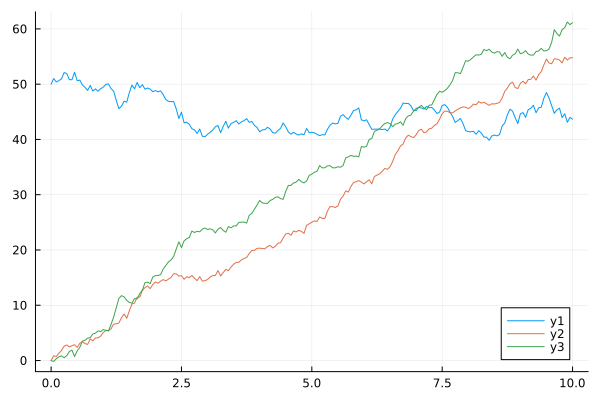

In [328]:
solmaybe = neuralsde(u0,cp4alt,st4)
plot(solmaybe[1].t,Array(solmaybe[1])')

In [111]:
function predict_neuralsde(p, u = u0)
  sdep = p#ComponentArray(drift = p, diffusion = p)
  return Array(neuralsde(u, sdep, st4)[1])[4]
end

predict_neuralsde (generic function with 2 methods)

In [113]:
predict_neuralsde(cp4alt)

51.788177f0

In [25]:
function predict_batch_neuralsde(p, u, n)
    res = map((x->predict_neuralsde(cp2, x)),[u for i in 1:n])
    VA = VectorOfArray(res)
    arr = convert(Array,VA)
end

predict_batch_neuralsde (generic function with 1 method)

In [27]:
function loss_neuralsde(p; n = 100)
  samples = predict_batch_neuralsde(p,u0,n)
  means = mean(samples, dims = 3)
  vars = var(samples, dims = 3, mean = means)
  testmeans = means[1,:,:]
  testvars = vars[1,:,:]
  loss = sum(abs2, truemean[1,:] - testmeans) + sum(abs2, truevar[1,:] - testvars)
  return loss#, means, vars
end

loss_neuralsde (generic function with 1 method)

In [86]:
@benchmark loss_neuralsde(cp2)

BenchmarkTools.Trial: 73 samples with 1 evaluation.
 Range (min … max):  46.235 ms … 134.731 ms  ┊ GC (min … max): 0.00% … 29.70%
 Time  (median):     59.477 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   68.755 ms ±  21.465 ms  ┊ GC (mean ± σ):  8.37% ± 13.55%

    ▁█   ▄                                                      
  ████▅▁▃█▅▅▅▆▁▃▃▁▃▁▁▃▃▅▁▃▅▃▁▁▅▅▅▆▃▃▃▁▁▁▃▃▅▁▁▁▁▁▁▁▃▁▁▁▃▁▁▁▁▁▁▃ ▁
  46.2 ms         Histogram: frequency by time          129 ms <

 Memory estimate: 51.25 MiB, allocs estimate: 794351.

In [87]:
Zygote.gradient(loss_neuralsde,cp2)

LoadError: MethodError: *(::TrackedArray{…,Base.ReshapedArray{Float32, 2, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{}}}, ::TrackedArray{…,Vector{Tracker.TrackedReal{Float32}}}) is ambiguous. Candidates:
  *(a::Tracker.TrackedMatrix{T}, b::AbstractVector{<:Tracker.TrackedReal}) where T<:Real in DistributionsAD at C:\Users\ChemeGrad2021\.julia\packages\DistributionsAD\DmZL8\src\tracker.jl:196
  *(x::Tracker.TrackedMatrix, y::Tracker.TrackedVector) in Tracker at C:\Users\ChemeGrad2021\.julia\packages\Tracker\9xWLl\src\lib\array.jl:427
  *(x::AbstractMatrix, y::Tracker.TrackedVector) in Tracker at C:\Users\ChemeGrad2021\.julia\packages\Tracker\9xWLl\src\lib\array.jl:426
Possible fix, define
  *(::Tracker.TrackedMatrix{T}, ::Tracker.TrackedVector{T} where T<:Tracker.TrackedReal) where T<:Real

In [88]:
opt = ADAM(0.025)

# First round of training with n = 10
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x), adtype)
optprob = Optimization.OptimizationProblem(optf, cp2)

OptimizationProblem. In-place: true
u0: ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (weight = Float32[0.25960022; -0.30979657; … ; -0.031265788; 0.004582677;;], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.52406216 -0.04019169 … 0.09613995 -0.43319982; -0.49755725 -0.38893697 … 0.050055284 -0.52704877], bias = Float32[0.0; 0.0;;]), layer_4 = Float32[])

In [89]:
result1 = Optimization.solve(optprob, opt, maxiters = 100)

LoadError: MethodError: *(::TrackedArray{…,Base.ReshapedArray{Float32, 2, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{}}}, ::TrackedArray{…,Vector{Tracker.TrackedReal{Float32}}}) is ambiguous. Candidates:
  *(a::Tracker.TrackedMatrix{T}, b::AbstractVector{<:Tracker.TrackedReal}) where T<:Real in DistributionsAD at C:\Users\ChemeGrad2021\.julia\packages\DistributionsAD\DmZL8\src\tracker.jl:196
  *(x::Tracker.TrackedMatrix, y::Tracker.TrackedVector) in Tracker at C:\Users\ChemeGrad2021\.julia\packages\Tracker\9xWLl\src\lib\array.jl:427
  *(x::AbstractMatrix, y::Tracker.TrackedVector) in Tracker at C:\Users\ChemeGrad2021\.julia\packages\Tracker\9xWLl\src\lib\array.jl:426
Possible fix, define
  *(::Tracker.TrackedMatrix{T}, ::Tracker.TrackedVector{T} where T<:Tracker.TrackedReal) where T<:Real